In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 64
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))



488396 4883 1526 1221


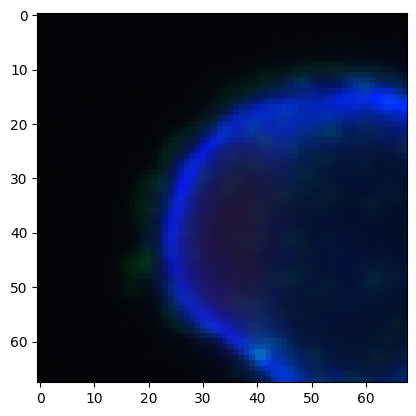

In [3]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [4]:
# test to see if the shape is correct

x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 68, 68]) torch.Size([64])


In [5]:
from models import VAE_LAFARGE
from loss_functions import loss_function

model = VAE_LAFARGE(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

VAE_LAFARGE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(256, eps=1e-05, mo

In [6]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])


# Training

In [7]:
val = True

num_epochs = 100

train_loss = []
train_mse_loss = []
train_kld_loss = []
val_loss = []
val_mse_loss = []
val_kld_loss = []
best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    if val:
        model.eval()
        batch_loss = []
        batch_mse_loss = []
        batch_kld_loss = []
        for x, y in val_loader:
            if cuda:
                x = x.cuda()

            output_val = model(x)
            x_hat, mu, sigma = output_val["x_hat"], output_val["mu"], output_val["sigma"]
            loss_fn = loss_function(x, x_hat, mu, sigma)
            loss = loss_fn["loss"]
            mse_loss = loss_fn["MSE"]
            kld_loss = loss_fn["KLD"]

            batch_loss.append(loss.item())
            batch_mse_loss.append(mse_loss.item())
            batch_kld_loss.append(kld_loss.item())

        val_loss.append(np.mean(batch_loss))
        val_mse_loss.append(np.mean(batch_mse_loss))
        val_kld_loss.append(np.mean(batch_kld_loss))

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best_model.pth")



    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}")




Epoch 1/100, loss: 10022.870298280546, mse_loss: 7973.5170668446335, kld_loss: 2049.353232635867, val_loss: 6159.918797348485, val_mse_loss: 4262.399809966216, val_kld_loss: 1897.5189818836059
Epoch 2/100, loss: 7678.194980512748, mse_loss: 5631.162313467163, kld_loss: 2047.0326644456852, val_loss: 6461.171876999514, val_mse_loss: 4314.512972845004, val_kld_loss: 2146.6589021549958
Epoch 3/100, loss: 7151.838049618895, mse_loss: 5097.847867741879, kld_loss: 2053.9901803520743, val_loss: 5661.5535405789315, val_mse_loss: 3647.918672178926, val_kld_loss: 2013.6348698996403
Epoch 4/100, loss: 6894.042147581533, mse_loss: 4844.394188813149, kld_loss: 2049.647962818228, val_loss: 5587.447073671683, val_mse_loss: 3544.390394256117, val_kld_loss: 2043.0566768161982
Epoch 5/100, loss: 6754.023998278466, mse_loss: 4690.627018372495, kld_loss: 2063.396983280842, val_loss: 5454.1399399666, val_mse_loss: 3380.4896583150976, val_kld_loss: 2073.6502762528153
Epoch 6/100, loss: 6627.126563139976, mse

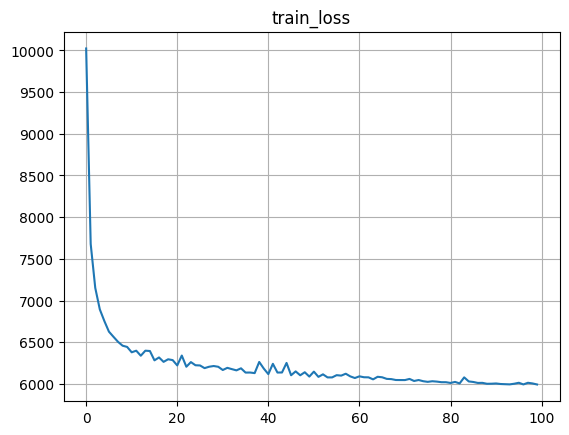

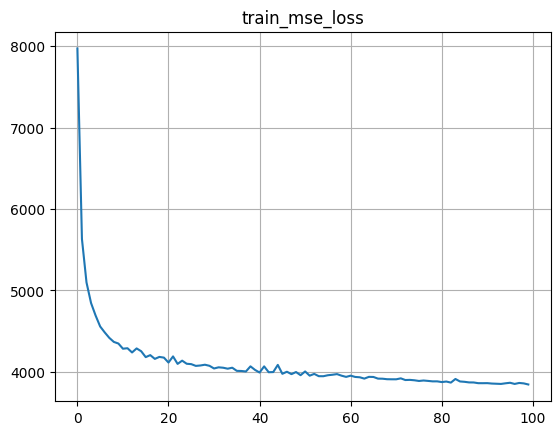

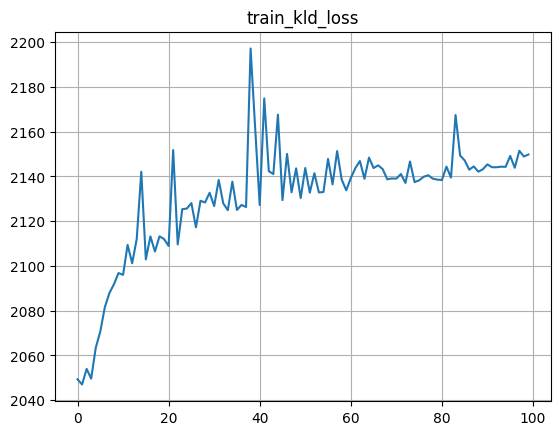

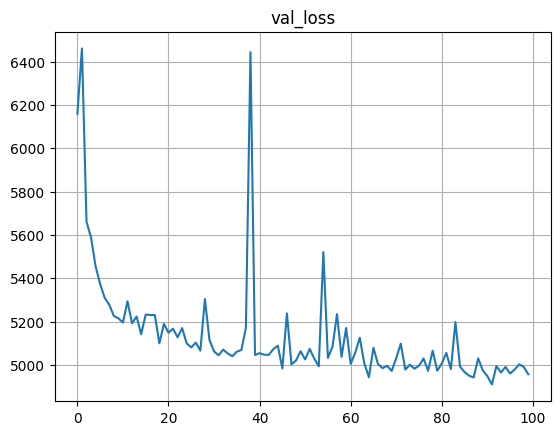

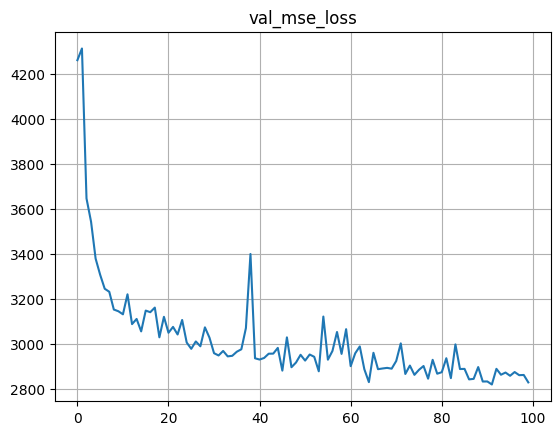

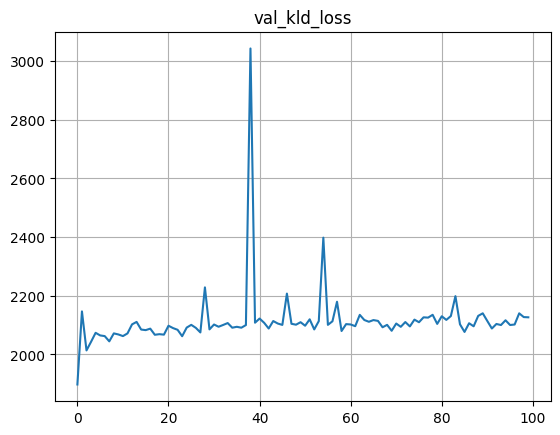

In [8]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss
loss_data["val_loss"] = val_loss
loss_data["val_mse_loss"] = val_mse_loss
loss_data["val_kld_loss"] = val_kld_loss
loss_plots(loss_data, invidual_plots=True)

df = pd.DataFrame(loss_data)
try:
    old_df = pd.read_csv(f"{model.__class__.__name__}_loss_data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(f"{model.__class__.__name__}_loss_data.csv", index=False)


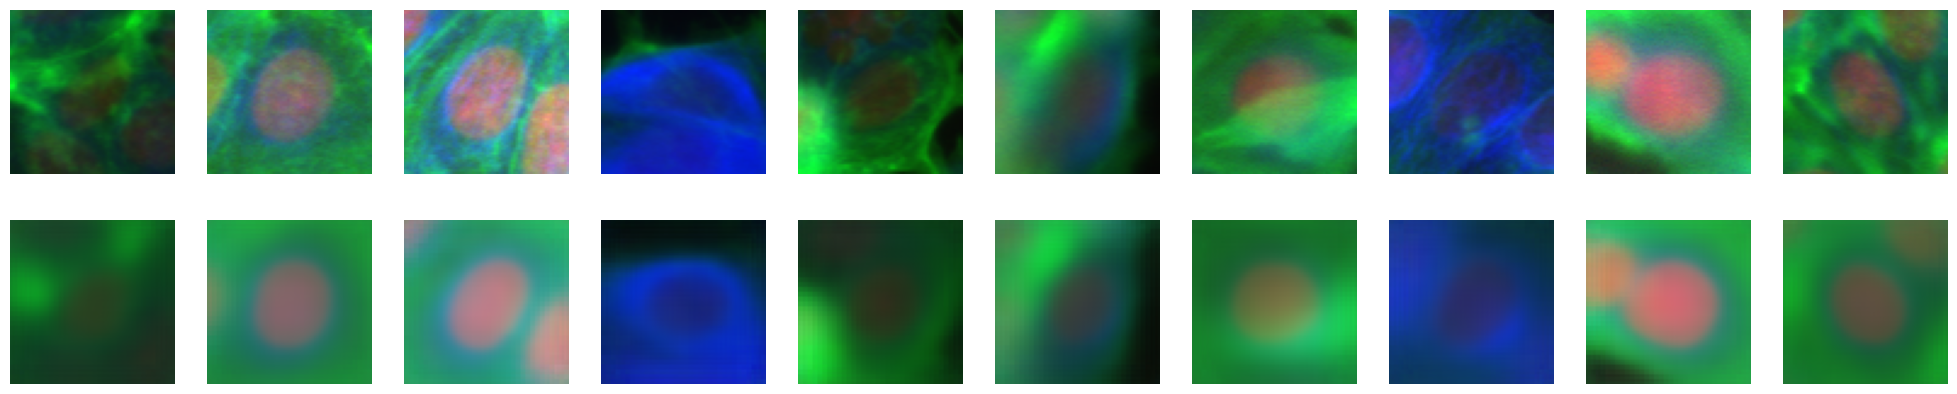

In [10]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))
plt.savefig("VAE_LAFARGE_reconstruction_mean_1.png")

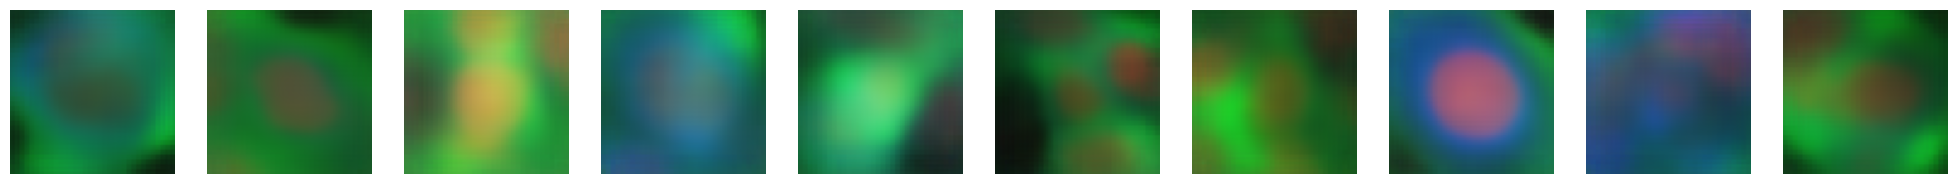

<Figure size 640x480 with 0 Axes>

In [11]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)
plt.savefig("VAE_LAFARGE_reconstruction_mean_2.png")